# Prolific Study Evaluation
This notebook loads and processes the raw data collected on Supabase from the online human study done via Prolific.
It reconstructs participant-level and trial-level responses from the stored jsPsych logs,
and prepares clean analysis tables for downstream statistical evaluation.

In [1]:
import os
from dotenv import load_dotenv
from supabase import create_client
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from PIL import Image
from scipy import stats
import numpy as np

load_dotenv()

SUPABASE_URL = "https://utwhgfveotpusdjopcnl.supabase.co"
SUPABASE_KEY = os.environ["SUPABASE_SERVICE_ROLE"]

supabase = create_client(SUPABASE_URL, SUPABASE_KEY)

# Base data folder
WORK = Path(os.environ.get("WORK", Path.cwd()))
DATA = WORK / "color-concept-entanglement" / "data"

In [2]:
# Read out results table and print as dataframe
response = supabase.table("results").select("*").execute()

rows = response.data
df_raw = pd.DataFrame(rows)

# Drop all test and debug participants
df_raw = df_raw[(~df_raw['prolific_pid'].str.startswith('DEBUG')) &
    (~df_raw['prolific_pid'].str.startswith('TEST_'))
].copy()

cutoff = pd.Timestamp("2026-02-02 16:17:47.53495", tz="UTC")
df_raw = df_raw[pd.to_datetime(df_raw["created_at"], utc=True) >= cutoff]

display(df_raw)
print(df_raw.shape)

,id,prolific_pid,profile_id,exit_reason,created_at,data,exit_time,experiment_start_time,profile_index
78,bc1e3e42-3cab-4038-b454-0b62538b50e4,61fa9062d42cb19beec49109,profile_15_first,completed,2026-02-02T16:17:47.53495+00:00,"[{'rt': 111361, 'study_id': '6962232f30c21461e...",1770049065996,1770048273488,12
79,da4ba4ae-22e4-4b68-b937-452941ef7692,6658c4239af9537eefdfbcc9,profile_8_last,completed,2026-02-02T16:23:55.441858+00:00,"[{'rt': 2853, 'study_id': '6962232f30c21461e6a...",1770049434084,1770049010274,71
80,bdbe211a-2848-4110-9417-d8e6eec10ce5,5f1833a16e55c522eeaf4dbe,profile_34_last,completed,2026-02-02T16:26:58.937637+00:00,"[{'rt': 8480, 'study_id': '6962232f30c21461e6a...",1770049617054,1770049011889,55
81,957d2d63-ac59-4d50-b8d4-4d0353e37b74,6685890808f9d444080810b4,profile_16_first,completed,2026-02-02T16:27:09.660883+00:00,"[{'rt': 18942, 'study_id': '6962232f30c21461e6...",1770049628208,1770048787426,14


(4, 9)


In [55]:
# Explode df_raw into trial-level df 
rows = []

for _, row in df_raw.iterrows():
    pid = row["prolific_pid"]
    profile_id = row["profile_id"]
    exit_reason = row["exit_reason"]

    if profile_id.endswith("_first"):
        intro_position = "first"
    elif profile_id.endswith("_last"):
        intro_position = "last"
    else:
        intro_position = None

    for trial in row["data"]:
        flat = {
            "PROLIFIC_PID": pid,
            "profile_id": profile_id,
            "exit_reason": exit_reason,
            "intro_position": intro_position,
        }
        flat.update(trial)
        rows.append(flat)

df = pd.DataFrame(rows)
df = df.dropna(axis=1, how="all")

display(df.head(10))
print("Shape:", df.shape)


,PROLIFIC_PID,profile_id,exit_reason,intro_position,rt,study_id,exit_time,timed_out,session_id,subject_id,...,percent_colored,initial_certainty,first_certainty_time,second_certainty_time,certainty_change_count,passed,sanity_id,question_order,response_index,correct_response
0,61fa9062d42cb19beec49109,profile_15_first,completed,first,111361.0,6962232f30c21461e6a14157,1770049065996,True,6980ca968d8ba61f2c712b17,61fa9062d42cb19beec49109,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,61fa9062d42cb19beec49109,profile_15_first,completed,first,36461.0,6962232f30c21461e6a14157,1770049065996,True,6980ca968d8ba61f2c712b17,61fa9062d42cb19beec49109,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,61fa9062d42cb19beec49109,profile_15_first,completed,first,NaN,6962232f30c21461e6a14157,1770049065996,True,6980ca968d8ba61f2c712b17,61fa9062d42cb19beec49109,...,60.0,10.0,12276.2,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,61fa9062d42cb19beec49109,profile_15_first,completed,first,NaN,6962232f30c21461e6a14157,1770049065996,True,6980ca968d8ba61f2c712b17,61fa9062d42cb19beec49109,...,60.0,10.0,8079.2,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,61fa9062d42cb19beec49109,profile_15_first,completed,first,NaN,6962232f30c21461e6a14157,1770049065996,True,6980ca968d8ba61f2c712b17,61fa9062d42cb19beec49109,...,55.0,7.0,11133.9,NaN,1.0,NaN,NaN,NaN,NaN,NaN
5,61fa9062d42cb19beec49109,profile_15_first,completed,first,NaN,6962232f30c21461e6a14157,1770049065996,True,6980ca968d8ba61f2c712b17,61fa9062d42cb19beec49109,...,90.0,10.0,5066.4,NaN,1.0,NaN,NaN,NaN,NaN,NaN
6,61fa9062d42cb19beec49109,profile_15_first,completed,first,4398.0,6962232f30c21461e6a14157,1770049065996,True,6980ca968d8ba61f2c712b17,61fa9062d42cb19beec49109,...,NaN,NaN,NaN,NaN,NaN,True,1.0,[0],4.0,Strongly Disagree
7,61fa9062d42cb19beec49109,profile_15_first,completed,first,NaN,6962232f30c21461e6a14157,1770049065996,True,6980ca968d8ba61f2c712b17,61fa9062d42cb19beec49109,...,20.0,6.0,11913.6,NaN,1.0,NaN,NaN,NaN,NaN,NaN
8,61fa9062d42cb19beec49109,profile_15_first,completed,first,NaN,6962232f30c21461e6a14157,1770049065996,True,6980ca968d8ba61f2c712b17,61fa9062d42cb19beec49109,...,60.0,8.0,4779.4,NaN,1.0,NaN,NaN,NaN,NaN,NaN
9,61fa9062d42cb19beec49109,profile_15_first,completed,first,NaN,6962232f30c21461e6a14157,1770049065996,True,6980ca968d8ba61f2c712b17,61fa9062d42cb19beec49109,...,55.0,8.0,3780.3,NaN,1.0,NaN,NaN,NaN,NaN,NaN


Shape: (429, 43)


In [4]:
print("Task type counts:")
print(df["task_type"].value_counts())
print("\nExit reason counts:")
print(df_raw["exit_reason"].value_counts(dropna=False))

Task type counts:
task_type
color_judgment    400
sanity             20
introspection       4
warning             1
Name: count, dtype: int64

Exit reason counts:
exit_reason
completed    4
Name: count, dtype: int64


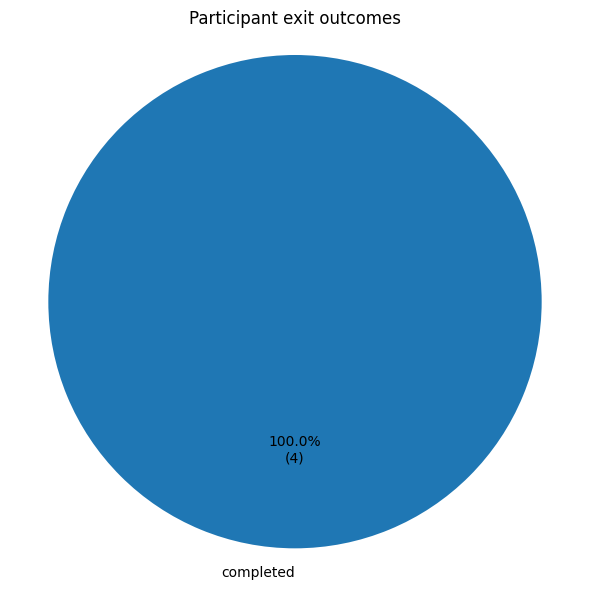

In [5]:
# Dropouts vs completions
exit_counts = df_raw['exit_reason'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    exit_counts,
    labels=exit_counts.index,
    autopct=lambda p: f"{p:.1f}%\n({int(round(p/100 * exit_counts.sum()))})",
    startangle=90,
    counterclock=False,
)
plt.title("Participant exit outcomes")
plt.axis("equal")
plt.tight_layout()
plt.show()

## Failed by distractor colors

In [ ]:
# Inpect failed distractor trials
df_failed = df[
    (df["task_type"] == "color_judgment") &
    (df["exit_reason"] == "failed_distractor") &
    (df["target_color"] != df["response_label"]) &
    (df["response_label"] != "white")
].copy()

print(f"Number of failed trials: {len(df_failed)}")
display(df_failed[[
    "PROLIFIC_PID",
    "object",
    "variant_region",
    "percent_colored",
    "target_color",
    "response_label",
    "image_path"
]])

for _, row in df_failed.iterrows():
    img_path = DATA / Path(row["image_path"])
    if img_path.exists():
        img = Image.open(img_path).convert("RGB")
        display(img)

Number of failed trials: 0


,PROLIFIC_PID,object,variant_region,percent_colored,target_color,response_label,image_path


## Succesfull completions

In [56]:
# Extract only valid color judgments for analysis)
df_complete = df[
    (df["task_type"] == "color_judgment") &
    (df["exit_reason"] == "completed") 
].copy()

# Drop emtpy columns (those cary information for introspection or attention checks)
before = df_complete.shape[1]
df_complete = df_complete.dropna(axis=1, how="all")
after = df_complete.shape[1]

print(f"Dropped {before - after} empty columns")

len(df_complete)

Dropped 10 empty columns


400

Number of warnings (wrong responses): 1


,PROLIFIC_PID,object,variant_region,percent_colored,target_color,response_label,image_path
82,61fa9062d42cb19beec49109,waffle iron,FG,30.0,red,green,color_images/gpt-4o/image_priors/waffle_iron_1...


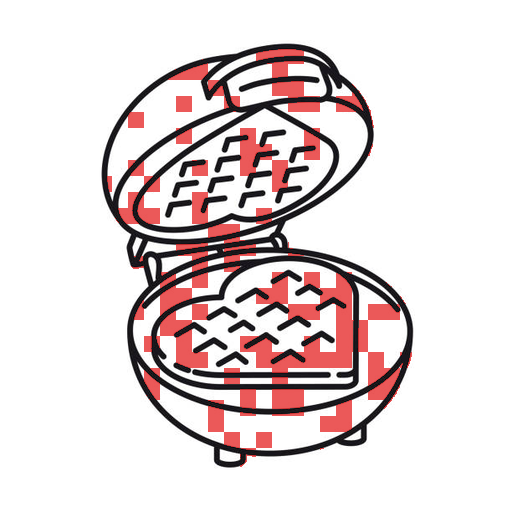

In [59]:
# Warnings
df_warnings = df_complete[(df_complete["target_color"] != df_complete["response_label"]) &
            (df_complete["response_label"] != "white")]

print(f"Number of warnings (wrong responses): {len(df_warnings)}")
display(df_warnings[[
    "PROLIFIC_PID",
    "object",
    "variant_region",
    "percent_colored",
    "target_color",
    "response_label",
    "image_path"
]])

for _, row in df_warnings.iterrows():
    img_path = DATA / Path(row["image_path"])
    if img_path.exists():
        img = Image.open(img_path).convert("RGB")
        display(img)

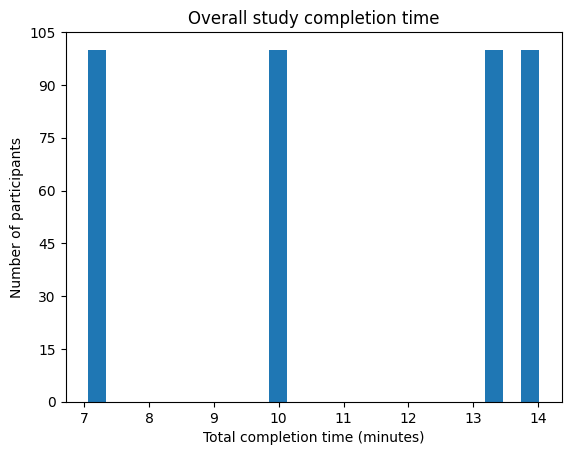

In [11]:
# Participant-level completion time (minutes) 
df_complete['experiment_start_time'] = pd.to_datetime(
    df_complete['experiment_start_time'], unit='ms'
)
df_complete['exit_time'] = pd.to_datetime(
    df_complete['exit_time'], unit='ms'
)

df_complete['total_time_min'] = (
    df_complete['exit_time'] - df_complete['experiment_start_time']
).dt.total_seconds() / 60

# Plot
plt.figure()
plt.hist(df_complete['total_time_min'], bins=25)
plt.xlabel('Total completion time (minutes)')
plt.ylabel('Number of participants')
plt.title('Overall study completion time')
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

### Accuracy vs. coloring fraction

In [12]:
# Accuracy: response must match target_color
df_complete.loc[df_complete["variant_region"] == "BG", "target_color"] = "white" # Fix wrong labels for BG, will be fixed in future study runs
df_complete["accuracy"] = (df_complete["response_label"] == df_complete["target_color"]).astype(float)
df_complete["accuracy"].mean()

np.float64(0.705)

In [13]:
grouped = df_complete.groupby(["variant_region", "percent_colored"])

summary = grouped["accuracy"].agg(
    mean="mean",
    std="std",
    n="count"
).reset_index()

# Optional: 95% CI
summary["ci"] = (
    stats.t.ppf(0.975, summary["n"] - 1)
    * (summary["std"] / np.sqrt(summary["n"]))
)


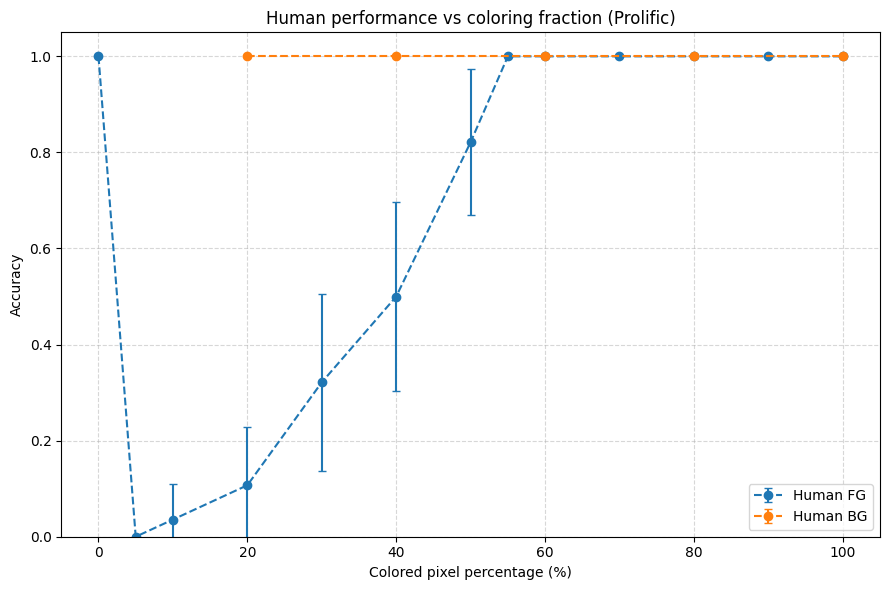

In [14]:
fig, ax = plt.subplots(figsize=(9, 6))

colors = {
    "FG": "#1f77b4",
    "BG": "#ff7f0e",
}

for region in ["FG", "BG"]:
    sub = summary[summary["variant_region"] == region]
    if sub.empty:
        continue

    ax.errorbar(
        sub["percent_colored"],
        sub["mean"],
        yerr=sub["ci"],
        fmt="o--",
        color=colors[region],
        capsize=3,
        label=f"Human {region}",
    )

ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Accuracy")
ax.set_ylim(0, 1.05)
ax.set_title("Human performance vs coloring fraction (Prolific)")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()


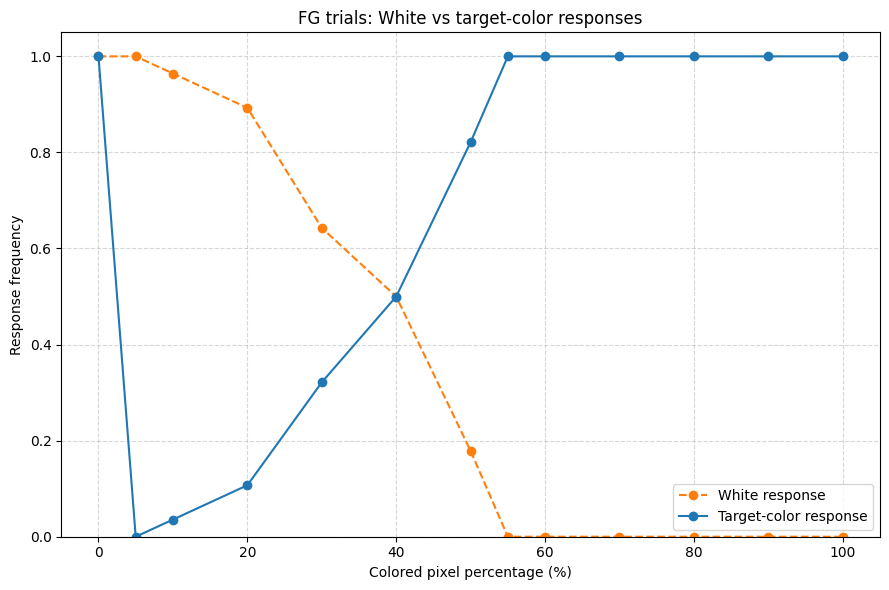

In [15]:
df_fg = df_complete[df_complete["variant_region"] == "FG"].copy()

df_fg["is_white"] = df_fg["response_label"] == "white"
df_fg["is_target"] = df_fg["response_label"] == df_fg["target_color"]

fg_summary = (
    df_fg
    .groupby("percent_colored")
    .agg(
        p_white=("is_white", "mean"),
        p_target=("is_target", "mean"),
        n=("is_white", "count")
    )
    .reset_index()
)

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(
    fg_summary["percent_colored"],
    fg_summary["p_white"],
    "o--",
    label="White response",
    color="#ff7f0e",
)

ax.plot(
    fg_summary["percent_colored"],
    fg_summary["p_target"],
    "o-",
    label="Target-color response",
    color="#1f77b4",
)

ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Response frequency")
ax.set_ylim(0, 1.05)
ax.set_title("FG trials: White vs target-color responses")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()

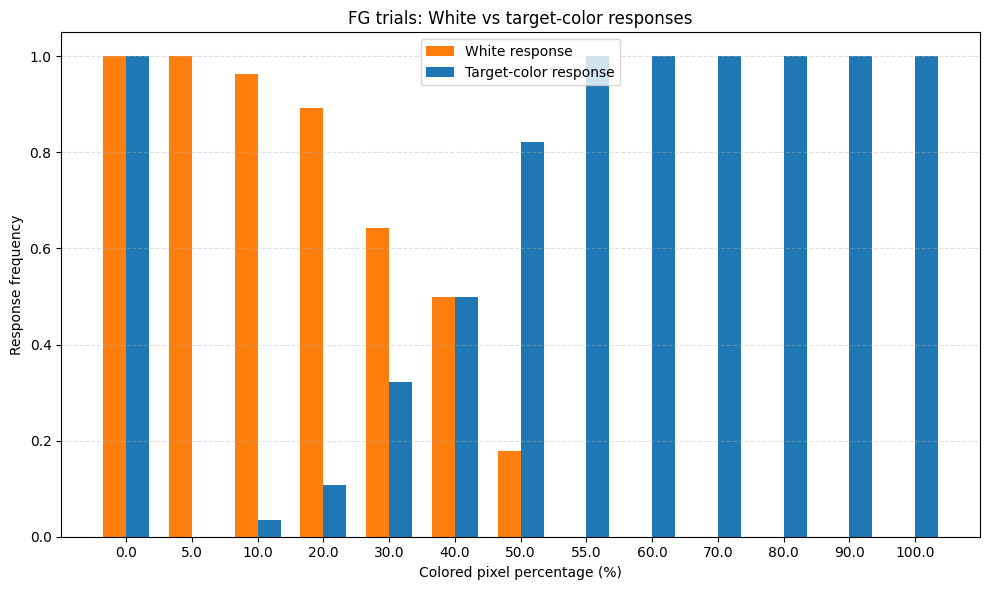

In [16]:
x = np.arange(len(fg_summary))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(
    x - width / 2,
    fg_summary["p_white"],
    width,
    label="White response",
    color="#ff7f0e",
)

ax.bar(
    x + width / 2,
    fg_summary["p_target"],
    width,
    label="Target-color response",
    color="#1f77b4",
)

ax.set_xticks(x)
ax.set_xticklabels(fg_summary["percent_colored"])
ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Response frequency")
ax.set_ylim(0, 1.05)
ax.set_title("FG trials: White vs target-color responses")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


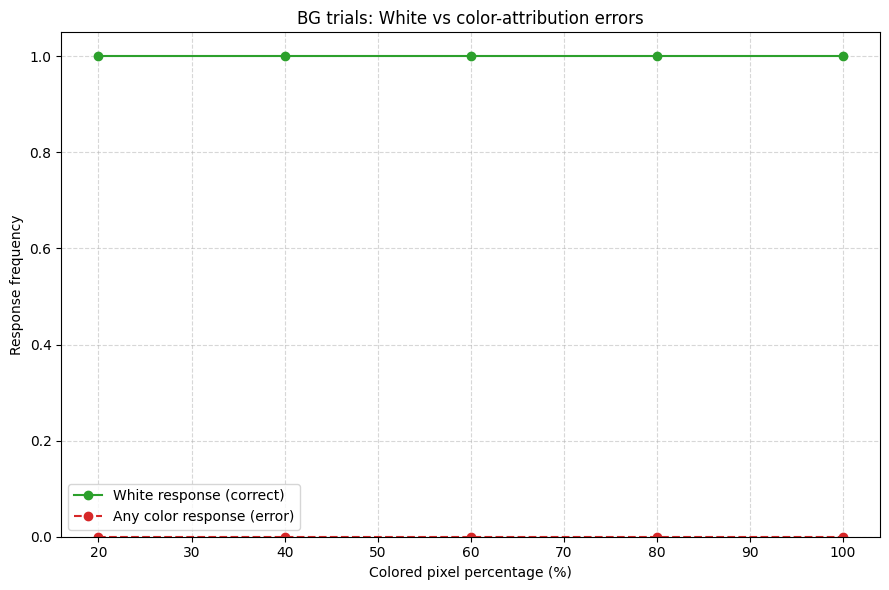

In [17]:
df_bg = df_complete[df_complete["variant_region"] == "BG"].copy()

df_bg["is_white"] = df_bg["response_label"] == "white"
df_bg["is_colored"] = ~df_bg["is_white"]

bg_summary = (
    df_bg
    .groupby("percent_colored")
    .agg(
        p_white=("is_white", "mean"),
        p_colored=("is_colored", "mean"),
        n=("is_white", "count")
    )
    .reset_index()
)

fig, ax = plt.subplots(figsize=(9, 6))

ax.plot(
    bg_summary["percent_colored"],
    bg_summary["p_white"],
    "o-",
    label="White response (correct)",
    color="#2ca02c",
)

ax.plot(
    bg_summary["percent_colored"],
    bg_summary["p_colored"],
    "o--",
    label="Any color response (error)",
    color="#d62728",
)

ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Response frequency")
ax.set_ylim(0, 1.05)
ax.set_title("BG trials: White vs color-attribution errors")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()

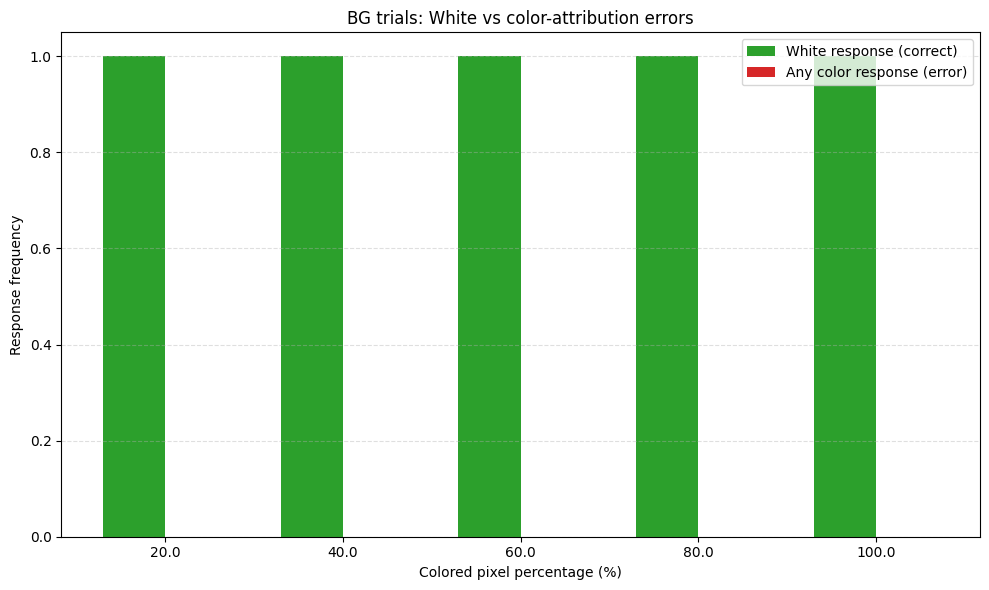

In [18]:
x = np.arange(len(bg_summary))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(
    x - width / 2,
    bg_summary["p_white"],
    width,
    label="White response (correct)",
    color="#2ca02c",
)

ax.bar(
    x + width / 2,
    bg_summary["p_colored"],
    width,
    label="Any color response (error)",
    color="#d62728",
)

ax.set_xticks(x)
ax.set_xticklabels(bg_summary["percent_colored"])
ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Response frequency")
ax.set_ylim(0, 1.05)
ax.set_title("BG trials: White vs color-attribution errors")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

### Certainty vs. coloring fraction

In [19]:
df_cert = df_complete.copy()

# Make sure certainty is numeric
df_cert["initial_certainty"] = pd.to_numeric(df_cert["initial_certainty"])
df_cert["final_certainty"] = pd.to_numeric(df_cert["final_certainty"])

# If final is missing, fall back to initial
df_cert["final_certainty"] = df_cert["final_certainty"].fillna(
    df_cert["initial_certainty"]
)

def summarize_certainty(df, value_col):
    grouped = df.groupby(["variant_region", "percent_colored"])
    summary = grouped[value_col].agg(
        mean="mean",
        std="std",
        n="count"
    ).reset_index()

    summary["ci"] = (
        stats.t.ppf(0.975, summary["n"] - 1)
        * (summary["std"] / np.sqrt(summary["n"]))
    )

    summary["certainty_type"] = value_col
    return summary

final_summary = summarize_certainty(df_cert, "final_certainty")
initial_summary = summarize_certainty(df_cert, "initial_certainty")

cert_summary = pd.concat([initial_summary, final_summary], ignore_index=True)

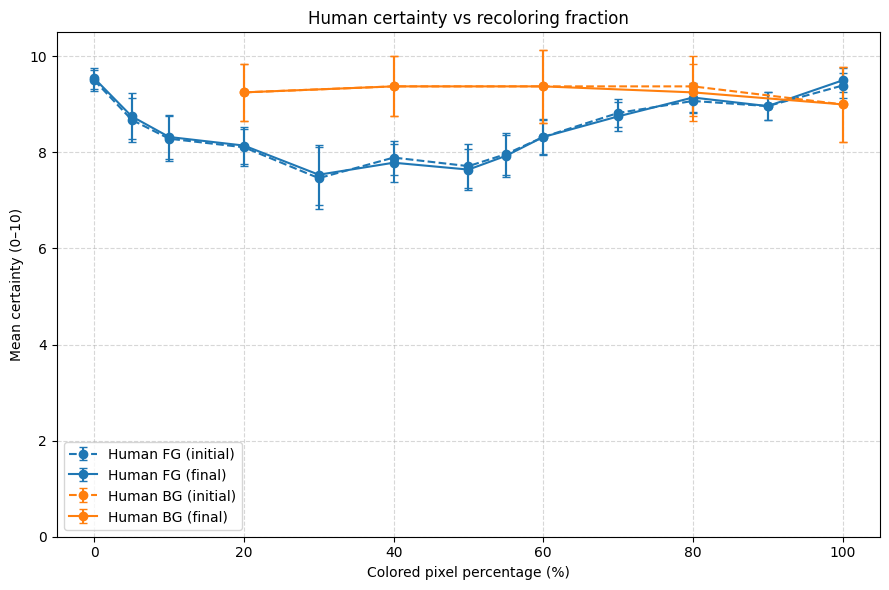

In [20]:
fig, ax = plt.subplots(figsize=(9, 6))

colors = {
    "FG": "#1f77b4",
    "BG": "#ff7f0e",
}

linestyles = {
    "initial_certainty": "--",
    "final_certainty": "-",
}

labels = {
    ("FG", "initial_certainty"): "Human FG (initial)",
    ("FG", "final_certainty"): "Human FG (final)",
    ("BG", "initial_certainty"): "Human BG (initial)",
    ("BG", "final_certainty"): "Human BG (final)",
}

for region in ["FG", "BG"]:
    for cert_type in ["initial_certainty", "final_certainty"]:
        sub = cert_summary[
            (cert_summary["variant_region"] == region) &
            (cert_summary["certainty_type"] == cert_type)
        ]

        if sub.empty:
            continue

        ax.errorbar(
            sub["percent_colored"],
            sub["mean"],
            yerr=sub["ci"],
            fmt="o",
            linestyle=linestyles[cert_type],
            color=colors[region],
            capsize=3,
            label=labels[(region, cert_type)],
        )

ax.set_xlabel("Colored pixel percentage (%)")
ax.set_ylabel("Mean certainty (0–10)")
ax.set_ylim(0, 10.5)
ax.set_title("Human certainty vs recoloring fraction")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()


## Response times

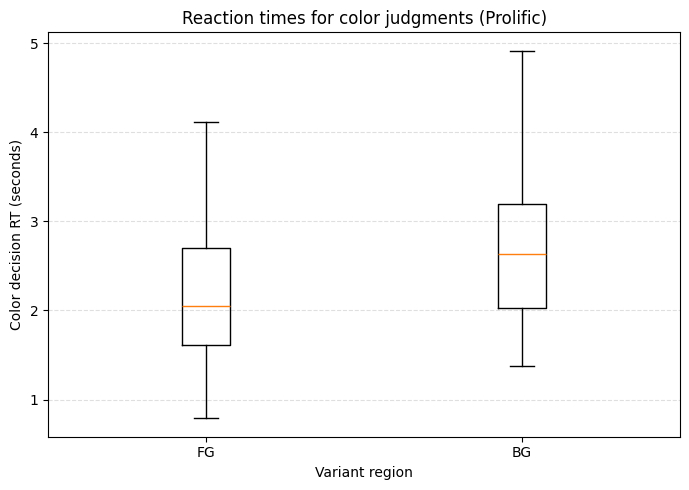

In [21]:
df_rt = df_complete.copy()

# ms → seconds
df_rt["color_time"] = df_rt["color_time"] / 1000

# keep valid RTs only
df_color_rt = df_rt[
    df_rt["color_time"].notna() &
    (df_rt["color_time"] > 0)
]

groups = [
    df_color_rt.loc[df_color_rt["variant_region"] == "FG", "color_time"].values,
    df_color_rt.loc[df_color_rt["variant_region"] == "BG", "color_time"].values,
]

plt.figure(figsize=(7, 5))
plt.boxplot(
    groups,
    tick_labels=["FG", "BG"],
    showfliers=False,
)

plt.xlabel("Variant region")
plt.ylabel("Color decision RT (seconds)")
plt.title("Reaction times for color judgments (Prolific)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [22]:
df_rt["final_certainty_time"] = df_rt["second_certainty_time"].fillna(
    df_rt["first_certainty_time"]
)

df_rt["rt_certainty_tot_sec"] = (
    (df_rt["final_certainty_time"] - df_rt["color_time"]) / 1000
)

df_rt = df_rt[
    df_rt["rt_certainty_tot_sec"].notna() &
    (df_rt["rt_certainty_tot_sec"] > 0)
]

df_rt["rt_certainty_revision_sec"] = (
    (df_rt["second_certainty_time"] - df_rt["first_certainty_time"]) / 1000
)

df_revision = df_rt[
    df_rt["rt_certainty_revision_sec"].notna() &
    (df_rt["rt_certainty_revision_sec"] > 0)
]

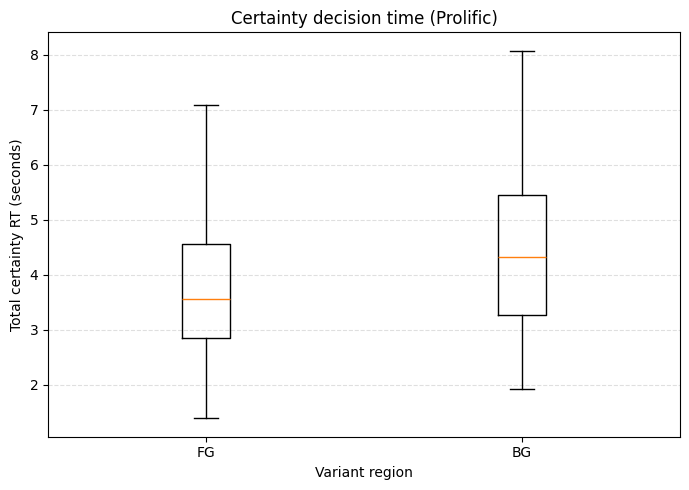

In [23]:
groups = [
    df_rt[df_rt["variant_region"] == "FG"]["rt_certainty_tot_sec"].values,
    df_rt[df_rt["variant_region"] == "BG"]["rt_certainty_tot_sec"].values,
]

plt.figure(figsize=(7, 5))
plt.boxplot(groups, tick_labels=["FG", "BG"], showfliers=False)
plt.xlabel("Variant region")
plt.ylabel("Total certainty RT (seconds)")
plt.title("Certainty decision time (Prolific)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
rev_rate = (
    df_complete["second_certainty_time"].notna()
    .groupby(df_complete["variant_region"])
    .mean()
)

print(rev_rate)

variant_region
BG    0.025000
FG    0.066667
Name: second_certainty_time, dtype: float64


## Introspection question

In [25]:
df[df["task_type"] == "introspection"][["intro_position","response", "slider_start"]]


,intro_position,response,slider_start
1,first,75,50.0
214,last,70,50.0
321,last,60,50.0
323,first,10,50.0


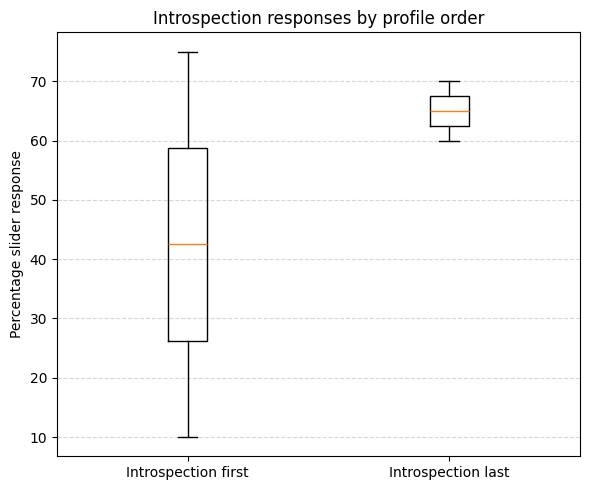

In [26]:
# Keep only introspection trials
df_intro = df[
    (df["task_type"] == "introspection") &
    (df["intro_position"].isin(["first", "last"]))
].copy()

groups = [
    df_intro[df_intro["intro_position"] == "first"]["response"].dropna(),
    df_intro[df_intro["intro_position"] == "last"]["response"].dropna(),
]

plt.figure(figsize=(6, 5))
plt.boxplot(
    groups,
    tick_labels=["Introspection first", "Introspection last"],
    showfliers=True,
)

plt.ylabel("Percentage slider response")
plt.title("Introspection responses by profile order")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

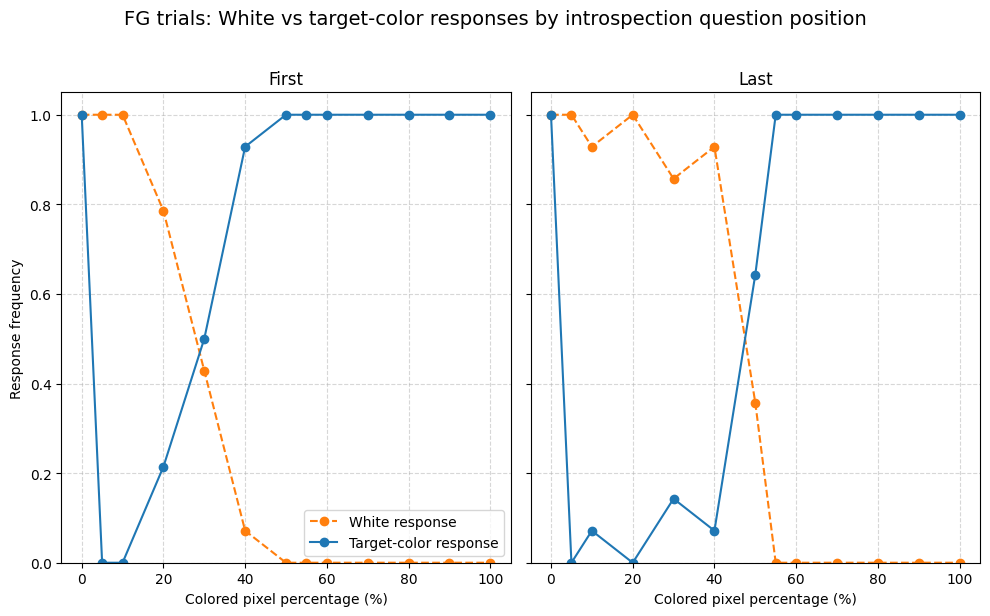

In [68]:
df_fg = df_complete[
    (df_complete["variant_region"] == "FG") &
    (df_complete["intro_position"].isin(["first", "last"]))
].copy()

df_fg["is_white"] = df_fg["response_label"] == "white"
df_fg["is_target"] = df_fg["response_label"] == df_fg["target_color"]

intro_positions = ["first", "last"]

fig, axes = plt.subplots(
    1, len(intro_positions),
    figsize=(5 * len(intro_positions), 6),
    sharey=True
)

fig.suptitle(
    "FG trials: White vs target-color responses by introspection question position",
    fontsize=14,
    y=1.02
)

if len(intro_positions) == 1:
    axes = [axes]

for ax, pos in zip(axes, intro_positions):
    df_sub = df_fg[df_fg["intro_position"] == pos]

    summary = (
        df_sub
        .groupby("percent_colored")
        .agg(
            p_white=("is_white", "mean"),
            p_target=("is_target", "mean"),
            n=("is_white", "count")
        )
        .reset_index()
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_white"],
        "o--",
        label="White response",
        color="#ff7f0e",
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_target"],
        "o-",
        label="Target-color response",
        color="#1f77b4",
    )

    ax.set_title(pos.capitalize())
    ax.set_xlabel("Colored pixel percentage (%)")
    ax.grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Response frequency")
axes[0].set_ylim(0, 1.05)
axes[0].legend()

plt.tight_layout()
plt.show()


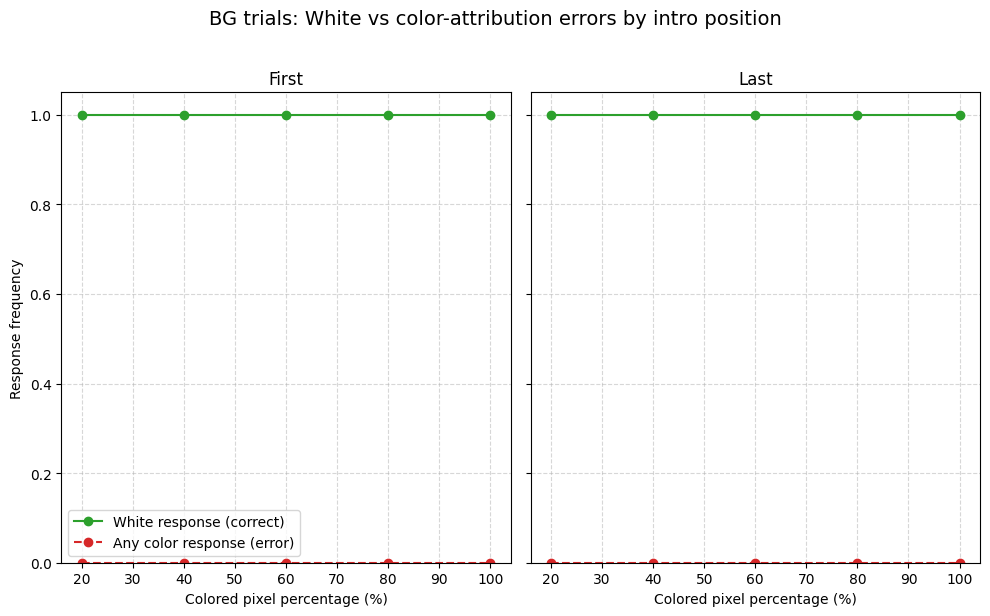

In [69]:
df_bg = df_complete[
    (df_complete["variant_region"] == "BG") &
    (df_complete["intro_position"].isin(["first", "last"]))
].copy()

df_bg["is_white"] = df_bg["response_label"] == "white"
df_bg["is_colored"] = ~df_bg["is_white"]

intro_positions = ["first", "last"]

fig, axes = plt.subplots(
    1, len(intro_positions),
    figsize=(5 * len(intro_positions), 6),
    sharey=True
)

fig.suptitle(
    "BG trials: White vs color-attribution errors by intro position",
    fontsize=14,
    y=1.02
)

if len(intro_positions) == 1:
    axes = [axes]

for ax, pos in zip(axes, intro_positions):
    df_sub = df_bg[df_bg["intro_position"] == pos]

    summary = (
        df_sub
        .groupby("percent_colored")
        .agg(
            p_white=("is_white", "mean"),
            p_colored=("is_colored", "mean"),
            n=("is_white", "count")
        )
        .reset_index()
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_white"],
        "o-",
        label="White response (correct)",
        color="#2ca02c",
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_colored"],
        "o--",
        label="Any color response (error)",
        color="#d62728",
    )

    ax.set_title(pos.capitalize())
    ax.set_xlabel("Colored pixel percentage (%)")
    ax.grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Response frequency")
axes[0].set_ylim(0, 1.05)
axes[0].legend()

plt.tight_layout()
plt.show()

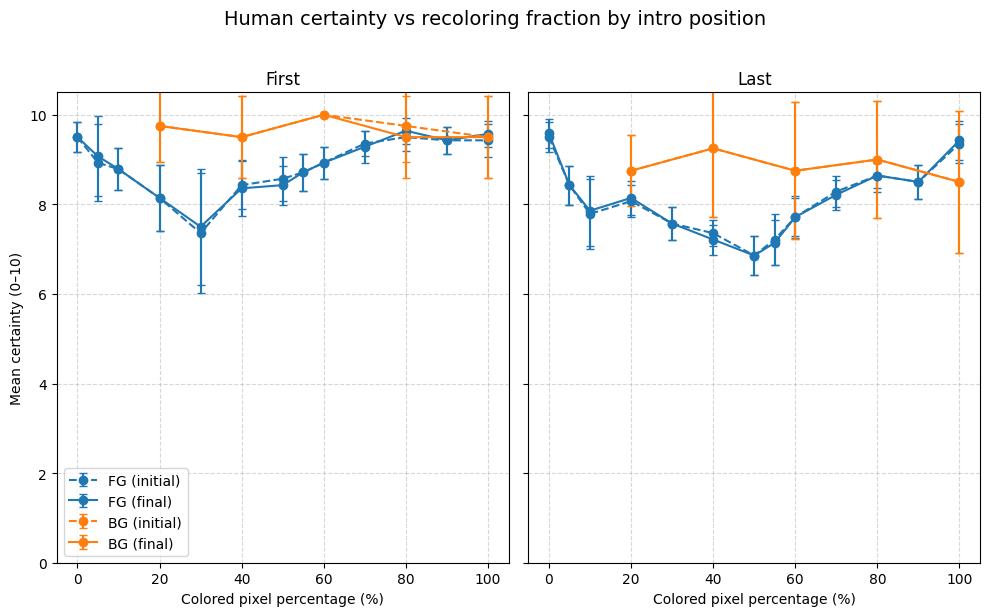

In [73]:
df_cert = df_complete[
    df_complete["intro_position"].isin(["first", "last"])
].copy()

df_cert["initial_certainty"] = pd.to_numeric(df_cert["initial_certainty"])
df_cert["final_certainty"] = pd.to_numeric(df_cert["final_certainty"])

df_cert["final_certainty"] = df_cert["final_certainty"].fillna(
    df_cert["initial_certainty"]
)

def summarize_certainty(df, value_col):
    grouped = df.groupby(
        ["intro_position", "variant_region", "percent_colored"]
    )
    summary = grouped[value_col].agg(
        mean="mean",
        std="std",
        n="count"
    ).reset_index()

    summary["ci"] = (
        stats.t.ppf(0.975, summary["n"] - 1)
        * (summary["std"] / np.sqrt(summary["n"]))
    )

    summary["certainty_type"] = value_col
    return summary

cert_summary = pd.concat(
    [
        summarize_certainty(df_cert, "initial_certainty"),
        summarize_certainty(df_cert, "final_certainty"),
    ],
    ignore_index=True
)

intro_positions = ["first", "last"]

fig, axes = plt.subplots(
    1, len(intro_positions),
    figsize=(5 * len(intro_positions), 6),
    sharey=True
)

fig.suptitle(
    "Human certainty vs recoloring fraction by intro position",
    fontsize=14,
    y=1.02
)

if len(intro_positions) == 1:
    axes = [axes]

colors = {"FG": "#1f77b4", "BG": "#ff7f0e"}
linestyles = {"initial_certainty": "--", "final_certainty": "-"}

labels = {
    ("FG", "initial_certainty"): "FG (initial)",
    ("FG", "final_certainty"): "FG (final)",
    ("BG", "initial_certainty"): "BG (initial)",
    ("BG", "final_certainty"): "BG (final)",
}

for ax, pos in zip(axes, intro_positions):
    for region in ["FG", "BG"]:
        for cert_type in ["initial_certainty", "final_certainty"]:
            sub = cert_summary[
                (cert_summary["intro_position"] == pos) &
                (cert_summary["variant_region"] == region) &
                (cert_summary["certainty_type"] == cert_type)
            ]

            if sub.empty:
                continue

            ax.errorbar(
                sub["percent_colored"],
                sub["mean"],
                yerr=sub["ci"],
                fmt="o",
                linestyle=linestyles[cert_type],
                color=colors[region],
                capsize=3,
                label=labels[(region, cert_type)],
            )

    ax.set_title(pos.capitalize())
    ax.set_xlabel("Colored pixel percentage (%)")
    ax.grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Mean certainty (0–10)")
axes[0].set_ylim(0, 10.5)
axes[0].legend()

plt.tight_layout()
plt.show()


## Split by stimulus type

In [61]:
df_complete.stimulus_type.value_counts()

stimulus_type
shape            176
correct_prior    176
counterfact       48
Name: count, dtype: int64

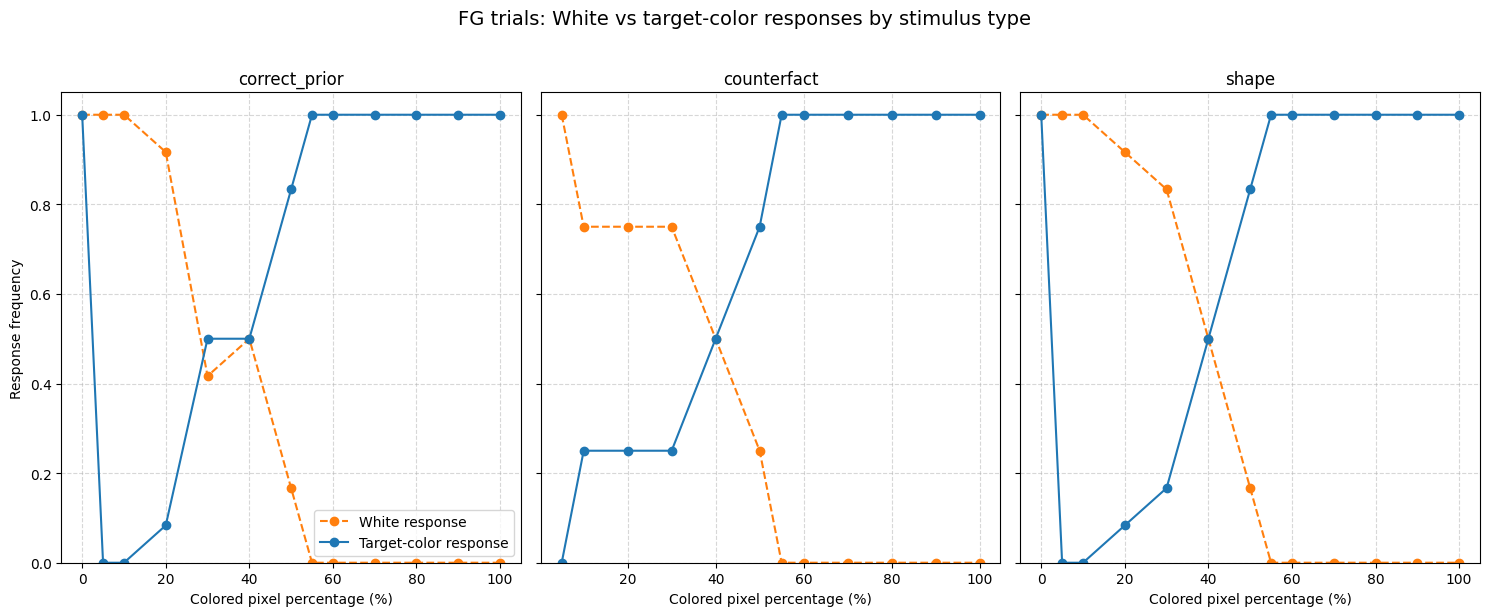

In [72]:
df_fg = df_complete[df_complete["variant_region"] == "FG"].copy()

df_fg["is_white"] = df_fg["response_label"] == "white"
df_fg["is_target"] = df_fg["response_label"] == df_fg["target_color"]

stimulus_types = sorted(df_fg["stimulus_type"].dropna().unique())

fig, axes = plt.subplots(
    1, len(stimulus_types),
    figsize=(5 * len(stimulus_types), 6),
    sharey=True
)

fig.suptitle(
    "FG trials: White vs target-color responses by stimulus type",
    fontsize=14,
    y=1.02
)

if len(stimulus_types) == 1:
    axes = [axes]

for ax, stim in zip(axes, stimulus_types):
    df_sub = df_fg[df_fg["stimulus_type"] == stim]

    summary = (
        df_sub
        .groupby("percent_colored")
        .agg(
            p_white=("is_white", "mean"),
            p_target=("is_target", "mean"),
            n=("is_white", "count")
        )
        .reset_index()
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_white"],
        "o--",
        label="White response",
        color="#ff7f0e",
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_target"],
        "o-",
        label="Target-color response",
        color="#1f77b4",
    )

    ax.set_title(f"{stim}")
    ax.set_xlabel("Colored pixel percentage (%)")
    ax.grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Response frequency")
axes[0].set_ylim(0, 1.05)
axes[0].legend()

plt.tight_layout()
plt.show()


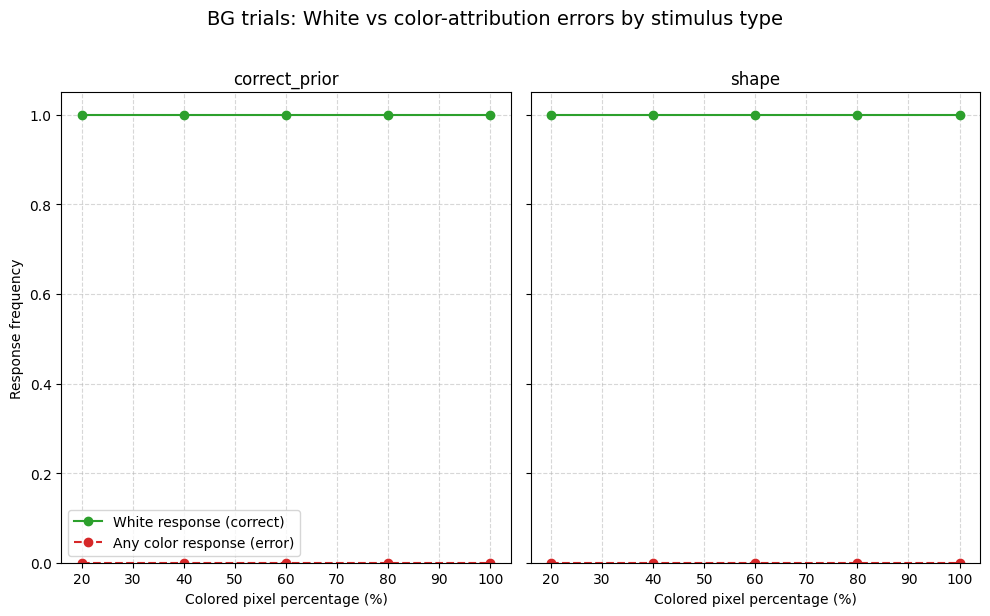

In [64]:
df_bg = df_complete[df_complete["variant_region"] == "BG"].copy()

df_bg["is_white"] = df_bg["response_label"] == "white"
df_bg["is_colored"] = ~df_bg["is_white"]

stimulus_types = sorted(df_bg["stimulus_type"].dropna().unique())

fig, axes = plt.subplots(
    1, len(stimulus_types),
    figsize=(5 * len(stimulus_types), 6),
    sharey=True
)

fig.suptitle(
    "BG trials: White vs color-attribution errors by stimulus type",
    fontsize=14,
    y=1.02
)

if len(stimulus_types) == 1:
    axes = [axes]

for ax, stim in zip(axes, stimulus_types):
    df_sub = df_bg[df_bg["stimulus_type"] == stim]

    summary = (
        df_sub
        .groupby("percent_colored")
        .agg(
            p_white=("is_white", "mean"),
            p_colored=("is_colored", "mean"),
            n=("is_white", "count")
        )
        .reset_index()
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_white"],
        "o-",
        label="White response (correct)",
        color="#2ca02c",
    )

    ax.plot(
        summary["percent_colored"],
        summary["p_colored"],
        "o--",
        label="Any color response (error)",
        color="#d62728",
    )

    ax.set_title(f"{stim}")
    ax.set_xlabel("Colored pixel percentage (%)")
    ax.grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Response frequency")
axes[0].set_ylim(0, 1.05)
axes[0].legend()

plt.tight_layout()
plt.show()


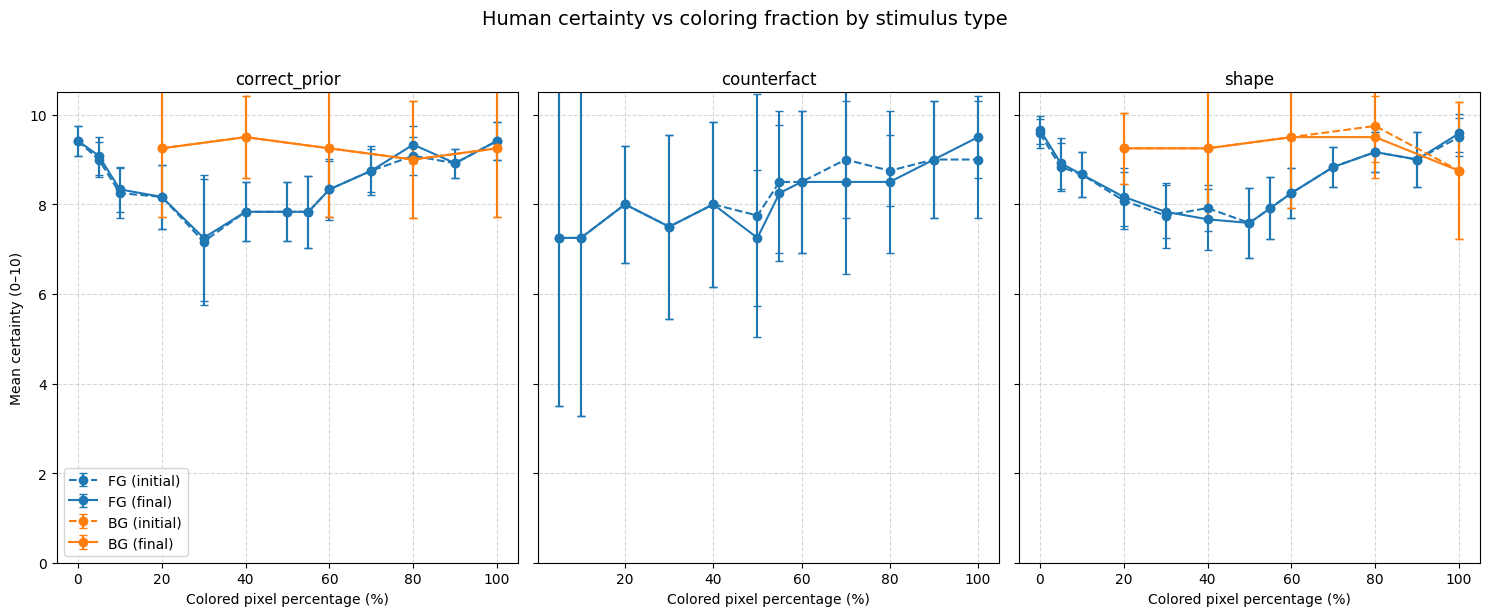

In [66]:
df_cert = df_complete.copy()

# Make sure certainty is numeric
df_cert["initial_certainty"] = pd.to_numeric(df_cert["initial_certainty"])
df_cert["final_certainty"] = pd.to_numeric(df_cert["final_certainty"])

# If final is missing, fall back to initial
df_cert["final_certainty"] = df_cert["final_certainty"].fillna(
    df_cert["initial_certainty"]
)

def summarize_certainty(df, value_col):
    grouped = df.groupby(
        ["stimulus_type", "variant_region", "percent_colored"]
    )
    summary = grouped[value_col].agg(
        mean="mean",
        std="std",
        n="count"
    ).reset_index()

    summary["ci"] = (
        stats.t.ppf(0.975, summary["n"] - 1)
        * (summary["std"] / np.sqrt(summary["n"]))
    )

    summary["certainty_type"] = value_col
    return summary

final_summary = summarize_certainty(df_cert, "final_certainty")
initial_summary = summarize_certainty(df_cert, "initial_certainty")

cert_summary = pd.concat(
    [initial_summary, final_summary],
    ignore_index=True
)

stimulus_types = sorted(df_cert["stimulus_type"].dropna().unique())

fig, axes = plt.subplots(
    1, len(stimulus_types),
    figsize=(5 * len(stimulus_types), 6),
    sharey=True
)

fig.suptitle(
    "Human certainty vs coloring fraction by stimulus type",
    fontsize=14,
    y=1.02
)

if len(stimulus_types) == 1:
    axes = [axes]

colors = {
    "FG": "#1f77b4",
    "BG": "#ff7f0e",
}

linestyles = {
    "initial_certainty": "--",
    "final_certainty": "-",
}

labels = {
    ("FG", "initial_certainty"): "FG (initial)",
    ("FG", "final_certainty"): "FG (final)",
    ("BG", "initial_certainty"): "BG (initial)",
    ("BG", "final_certainty"): "BG (final)",
}

for ax, stim in zip(axes, stimulus_types):
    for region in ["FG", "BG"]:
        for cert_type in ["initial_certainty", "final_certainty"]:
            sub = cert_summary[
                (cert_summary["stimulus_type"] == stim) &
                (cert_summary["variant_region"] == region) &
                (cert_summary["certainty_type"] == cert_type)
            ]

            if sub.empty:
                continue

            ax.errorbar(
                sub["percent_colored"],
                sub["mean"],
                yerr=sub["ci"],
                fmt="o",
                linestyle=linestyles[cert_type],
                color=colors[region],
                capsize=3,
                label=labels[(region, cert_type)],
            )

    ax.set_title(f"{stim}")
    ax.set_xlabel("Colored pixel percentage (%)")
    ax.grid(True, linestyle="--", alpha=0.5)

axes[0].set_ylabel("Mean certainty (0–10)")
axes[0].set_ylim(0, 10.5)
axes[0].legend()

plt.tight_layout()
plt.show()